###  Update From 12/29
#### Zihan

+ revised single factor into generic evaluations - [done]
+ for each feature, compute the sharpe ratio for cutoff ranging from 0.5 to 0.9 [done]
+ generate binary feature out of the previous computed mappings [done]
+ don't think adding article and alert would be helpful - will explain in person
+ aggregate sentiment into weekly and biweekly 


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import operator

with open('sectorMapping.pkl', 'rb') as f:
    sectorMapping = pickle.load(f)

# google drive link: https://drive.google.com/file/d/1IcuteDnhzD9xfkfVuUJrCEOFiFstzxF_/view?usp=sharing
df = pd.read_csv("ALL.csv")
df = df[abs(df.returnsOpenNextMktres10) < 0.40] # remove outlier
df['sector'] = df.assetCode.apply(lambda x: sectorMapping[x.split(".")[0]]) # create sector column

In [138]:
# single factor evaluation in a functional way

'''
helper function for single_factor_eva: top cut_off % short, else long
'''
def single_factor_helper(df, score, cut_off):
    d = {}
    sorted_df = df.sort_values(score).reset_index(drop=True)
    index = int(len(sorted_df) * cut_off)
    short_portfolio = np.mean(sorted_df['returnsOpenNextMktres10'][:index])
    long_portfolio = np.mean(sorted_df['returnsOpenNextMktres10'][index:])
    d['daily_return'] = long_portfolio - short_portfolio
    return pd.Series(d, index=['daily_return'])

'''
evaluate how well a single factor performs given its column name and a cutoff
    e.g. when cutoff is set to be 0.9, it means we short top 10%, and long 90%
@param cut_off float
@param score str name of the factor
@param df dataframe which must contain score column and returnsOpenNextMktres10
return NaN only plot and statistics
'''
def single_factor_eva(df, score, cut_off=0.5, sector_code=None, all_on=False):
    
    print("\n *** evaluating factor :", score)
    if sector_code != None:
        print("\n *** sector: ", sector_code)
        factor_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, cut_off))
        sector_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x[x.sector == sector_code], score, cut_off))
        print(" *** Overall Sharpe ratio:", float(factor_return.mean() / factor_return.std()))
        print(" *** Sector Sharpe ratio:", float(sector_return.mean() / sector_return.std()))
        factor_return['cumsum'] = factor_return.daily_return.cumsum()
        sector_return['cumsum'] = sector_return.daily_return.cumsum()
        plt.figure()
        plt.plot(list(factor_return['cumsum']), label = score+"_"+str(cut_off))
        plt.plot(list(sector_return['cumsum']), label = score+"_"+str(cut_off)+"_sector_" +str(sector_code))
        plt.legend()
        plt.savefig(score+"_"+str(cut_off)+"_sector_" +str(sector_code) +'.png')
        plt.show()
        return
    
    if all_on:
        plt.figure()
        cutoff_sharpe_dict = dict()
        df_group = df.groupby('datetime')
        for i in [0.1 * i for i in range(1, 10)]:
            print(i)
            cutoff_return = df_group.apply(lambda x: single_factor_helper(x, score, i))
            cutoff_sharpe_dict[round(i, 1)] = float(cutoff_return.mean() / cutoff_return.std())
            cutoff_return['cumsum'] = cutoff_return.daily_return.cumsum()
            plt.plot(list(cutoff_return['cumsum']), label = str(int(i * 100))+"%")
        plt.legend()
        title = ""
        for key in cutoff_sharpe_dict:
            title = title + str(key) + ": " + str(round(cutoff_sharpe_dict[key], 3)) + "\n"
        plt.title(score+":\n"+title)
        plt.savefig('./cutoff_images_v2/' + score + '.png', bbox_inches='tight')
        plt.show()    
        return cutoff_sharpe_dict
    
    factor_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, cut_off))
    factor_return['cumsum'] = factor_return.daily_return.cumsum()
    plt.figure()
    plt.plot(list(factor_return['cumsum']), label = score+"_"+str(int(cut_off * 100))+"%")
    plt.legend()
    plt.savefig(score+"_"+str(cut_off)+'.png')
    plt.show()  

### Examine Sector In and Out Performance with various cutoffs

In [6]:
examine_ls = [ 'alert_relevance_weighted_sentiment',
       'alert_relevance_weighted_negative_sentiment',
       'alert_relevance_weighted_positive_sentiment',
       'alert_relevance_weighted_neutral_sentiment',
       'alert_news_volume_sum_12H', 'alert_news_novelty_sum_12H',
       'alert_news_volume_sum_24H', 'alert_news_novelty_sum_24H',
       'alert_news_volume_sum_3D', 'alert_news_novelty_sum_3D',
       'alert_news_volume_sum_5D', 'alert_news_novelty_sum_5D',
       'alert_news_volume_sum_7D', 'alert_news_novelty_sum_7D',
       'article_relevance_weighted_sentiment',
       'article_relevance_weighted_negative_sentiment',
       'article_relevance_weighted_positive_sentiment',
       'article_relevance_weighted_neutral_sentiment',
       'article_news_volume_sum_12H', 'article_news_novelty_sum_12H',
       'article_news_volume_sum_24H', 'article_news_novelty_sum_24H',
       'article_news_volume_sum_3D', 'article_news_novelty_sum_3D',
       'article_news_volume_sum_5D', 'article_news_novelty_sum_5D',
       'article_news_volume_sum_7D', 'article_news_novelty_sum_7D',
       'relevance_weighted_sentiment', 'relevance_weighted_negative_sentiment',
       'relevance_weighted_positive_sentiment',
       'relevance_weighted_neutral_sentiment', 'news_volume_sum_12H',
       'news_novelty_sum_12H', 'news_volume_sum_24H', 'news_novelty_sum_24H',
       'news_volume_sum_3D', 'news_novelty_sum_3D', 'news_volume_sum_5D',
       'news_novelty_sum_5D', 'news_volume_sum_7D', 'news_novelty_sum_7D']

In [139]:
# run all sentiment related features and save them in local directory

sentiment_cutoff_dict = dict()
for i in examine_ls:
    sentiment_cutoff_dict[i] = single_factor_eva(df, i, all_on=True)


 *** evaluating factor : alert_relevance_weighted_sentiment
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : alert_relevance_weighted_negative_sentiment
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : alert_relevance_weighted_positive_sentiment
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : alert_relevance_weighted_neutral_sentiment
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : alert_news_volume_sum_12H
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : alert_news_novelty_sum_12H
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : alert_news_volume_sum_24H
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

/Users/zihang/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_novelty_sum_24H
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_volume_sum_3D
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_novelty_sum_3D
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_volume_sum_5D
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_novelty_sum_5D
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_volume_sum_7D
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9

 *** evaluating factor : article_news_novelty_sum_7D
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [140]:
cutoff_df = pd.DataFrame(sentiment_cutoff_dict) # df is good for column wise operations
cutoff_df = cutoff_df.abs()  # extreme is good, sign is not

# # uncomment to inspect rank
# cutoff_df.max().sort_values(ascending=False) # find top k by mean or max
# cutoff_df.mean().sort_values(ascending=False)

# maually selected top k most important features
top_k_factors = [
    'article_relevance_weighted_negative_sentiment',
    'article_news_volume_sum_5D',
    'article_relevance_weighted_positive_sentiment',
    'alert_news_volume_sum_5D',
    'alert_relevance_weighted_positive_sentiment',
    'alert_relevance_weighted_negative_sentiment',
    'article_news_novelty_sum_12H',
    'alert_news_novelty_sum_3D'
]

In [141]:
'''
given column name like: 'article_relevance_weighted_negative_sentiment'
return the quantile cutoff based on optimal single factor evaluation
'''
def cutoff_lookup(i):
    return cutoff_df[i].sort_values(ascending=False).index[0]

# test case for cutoff_lookup function - used min here because original dict had negative value for this feature
assert(cutoff_lookup('article_relevance_weighted_negative_sentiment') == \
       min(sentiment_cutoff_dict['article_relevance_weighted_negative_sentiment'].items(), key=operator.itemgetter(1))[0])
print("cutoff_lookup test case passed!")

cutoff_lookup test case passed!


In [158]:
# test case for bin_top_k_sentiment_factors

'''
provide a top_k_factors list of columns names, and df that contains them
return only the top k sentiment factors in binary encoding based on their optimal sharpe dict obtained earlier
'''
def bin_top_k_sentiment_factors(df, top_k_factors):
    d = {}
    for factor in top_k_factors:
        sorted_df = df.sort_values(factor).reset_index(drop=True)
        index = int(len(sorted_df) * cutoff_lookup(factor))
        index_value = float(sorted_df[factor].iloc[[index]])
        d[factor] = df[factor].apply(lambda x: 1 if x >= index_value else -1)
    d['returnsOpenNextMktres10'] = df.returnsOpenNextMktres10
    d['datetime'] = df.datetime
    return pd.DataFrame(d)

tmp = df.groupby('datetime').apply(lambda x: bin_top_k_sentiment_factors(x, top_k_factors))

def single_factor_helper(x, score):
    d = {}
    short_portfolio = np.mean(x[x[score] == -1].returnsOpenNextMktres10)
    long_portfolio = np.mean(x[x[score] == 1].returnsOpenNextMktres10)
    d['daily_return'] = long_portfolio - short_portfolio
    return pd.Series(d, index=['daily_return'])

In [159]:
for i in top_k_factors:
    ret = tmp.groupby('datetime').apply(lambda x: single_factor_helper(x, i))
    print("\n", i)
    print("benchmark max ", max(sentiment_cutoff_dict[i].values()))
    print("benchmark min ", min(sentiment_cutoff_dict[i].values()))
    print("binary...... ", float(ret.mean() / ret.std()))
# assert(min(sentiment_cutoff_dict['alert_relevance_weighted_negative_sentiment'].values()) - float(ret.mean() / ret.std()) < e)
# ret = tmp.groupby('datetime').apply(lambda x: single_factor_helper(x, 'alert_relevance_weighted_positive_sentiment'))
# assert(max(sentiment_cutoff_dict['alert_relevance_weighted_positive_sentiment'].values()) - float(ret.mean() / ret.std()) < e)
# print("binary top k sentiment factor passed test!")


 article_relevance_weighted_negative_sentiment
benchmark max  -0.07097892573710275
benchmark min  -0.10547548077235366
binary......  -0.1045339886591367

 article_news_volume_sum_5D
benchmark max  -0.0016463969127021964
benchmark min  -0.098564382463486
binary......  -0.09766731012761795

 article_relevance_weighted_positive_sentiment
benchmark max  0.09591264225125541
benchmark min  0.0452640986874217
binary......  0.09649712295948355

 alert_news_volume_sum_5D
benchmark max  -0.00017856722921002905
benchmark min  -0.10439747619835239
binary......  -0.1039127850066204

 alert_relevance_weighted_positive_sentiment
benchmark max  0.09446337650012954
benchmark min  0.011336875860654023
binary......  0.0942377415483772

 alert_relevance_weighted_negative_sentiment
benchmark max  -0.054392222924663676
benchmark min  -0.09398496179868948
binary......  -0.09397969055580116

 article_news_novelty_sum_12H
benchmark max  -0.0019398772981909444
benchmark min  -0.0610389263109162
binary......  -

In [ ]:
# test statistics
# binary matrix is about the same magnitude in sharpe in general

In [ ]:
# demo code of running all sector comparison for 'alert_relevance_weighted_positive_sentiment'
for i in list(df.sector.unique()):
    single_factor_eva(df, 'alert_relevance_weighted_positive_sentiment', 0.5, i)

### New Sentiment Feature Generations

+ test novelty combined with other features
    + test method: use linear regression to fit single and double factor model and examine cumulative return and overall sharpe
    + test novelty against all volume and all sentiments

In [128]:
novelty_ls = []
for i in examine_ls:
    if 'novelty' in i:
        novelty_ls.append(i)
print(novelty_ls)

['alert_news_novelty_sum_12H', 'alert_news_novelty_sum_24H', 'alert_news_novelty_sum_3D', 'alert_news_novelty_sum_5D', 'alert_news_novelty_sum_7D', 'article_news_novelty_sum_12H', 'article_news_novelty_sum_24H', 'article_news_novelty_sum_3D', 'article_news_novelty_sum_5D', 'article_news_novelty_sum_7D', 'news_novelty_sum_12H', 'news_novelty_sum_24H', 'news_novelty_sum_3D', 'news_novelty_sum_5D', 'news_novelty_sum_7D']


In [129]:
volume_ls = []
for i in examine_ls:
    if 'volume' in i:
        volume_ls.append(i)
print(volume_ls)

['alert_news_volume_sum_12H', 'alert_news_volume_sum_24H', 'alert_news_volume_sum_3D', 'alert_news_volume_sum_5D', 'alert_news_volume_sum_7D', 'article_news_volume_sum_12H', 'article_news_volume_sum_24H', 'article_news_volume_sum_3D', 'article_news_volume_sum_5D', 'article_news_volume_sum_7D', 'news_volume_sum_12H', 'news_volume_sum_24H', 'news_volume_sum_3D', 'news_volume_sum_5D', 'news_volume_sum_7D']


In [130]:
sentiment_ls = []
for i in examine_ls:
    if 'sentiment' in i:
        sentiment_ls.append(i)
print(sentiment_ls)

['alert_relevance_weighted_sentiment', 'alert_relevance_weighted_negative_sentiment', 'alert_relevance_weighted_positive_sentiment', 'alert_relevance_weighted_neutral_sentiment', 'article_relevance_weighted_sentiment', 'article_relevance_weighted_negative_sentiment', 'article_relevance_weighted_positive_sentiment', 'article_relevance_weighted_neutral_sentiment', 'relevance_weighted_sentiment', 'relevance_weighted_negative_sentiment', 'relevance_weighted_positive_sentiment', 'relevance_weighted_neutral_sentiment']


In [162]:
# VAR example
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = i + random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
# fit model
model = VAR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

[[100.59186739 101.04516415]]


-0.036053070252380054 -0.009492118673526975 0.010228750809856337 0.03649713167526531


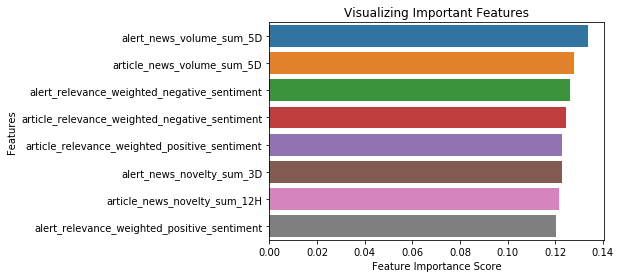

accuracy: 0.5095978081016064
confusion matrix: [[ 61775 178639]
 [ 59056 185224]]


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [230]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

q2 = tmp.returnsOpenNextMktres10.quantile(.2)
q4 = tmp.returnsOpenNextMktres10.quantile(.4)
q6 = tmp.returnsOpenNextMktres10.quantile(.6)
q8 = tmp.returnsOpenNextMktres10.quantile(.8)

q5 = tmp.returnsOpenNextMktres10.quantile(.5)
print(q2, q4, q6, q8)

def quantile_mapper(x):
    if x <= q2:
        return 1
    if x <= q4:
        return 2
    if x <= q6:
        return 3
    if x <= q8:
        return 4
    return 5

def binary_quantile_mapper(x):
    if x <= 0:
        return -1
    return 1

tmp['quantile'] = tmp.returnsOpenNextMktres10.apply(binary_quantile_mapper)

X = tmp[['article_relevance_weighted_negative_sentiment',
       'article_news_volume_sum_5D',
       'article_relevance_weighted_positive_sentiment',
       'alert_news_volume_sum_5D',
       'alert_relevance_weighted_positive_sentiment',
       'alert_relevance_weighted_negative_sentiment',
       'article_news_novelty_sum_12H', 'alert_news_novelty_sum_3D']]
y = tmp['quantile']

clf = RandomForestClassifier(n_estimators=500)  
clf.fit(X, y)  
tmp['y_pred'] = clf.predict(X)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

print("accuracy:", metrics.accuracy_score(y, tmp['y_pred']))
print("confusion matrix:", metrics.confusion_matrix(tmp['quantile'], tmp['y_pred']))

# let's write an evaluation for 5 class predictions, 1, 2, 3, 4, 5 - short on 1, 2 - long on 4, 5
def multi_class_eva(day_df):
    short_porfolio = day_df[(day_df.y_pred == 1) | (day_df.y_pred == 2)]
    long_porfolio  = day_df[(day_df.y_pred == 4) | (day_df.y_pred == 5)]
    return (long_porfolio.returnsOpenNextMktres10).mean() - (short_porfolio.returnsOpenNextMktres10).mean()

def binary_class_eva(day_df):
    short_porfolio = day_df[(day_df.y_pred == -1)]
    long_porfolio  = day_df[(day_df.y_pred == 1)]
    return (long_porfolio.returnsOpenNextMktres10).mean() - (short_porfolio.returnsOpenNextMktres10).mean()

def run_multi_eva(df, type_eva = 'multi_class'):
    tmp_ret = None
    if type_eva == "multi_class":
        tmp_ret = tmp.groupby("datetime").apply(lambda x: multi_class_eva(x))
    if type_eva == "binary_class":
        tmp_ret = tmp.groupby("datetime").apply(lambda x: binary_class_eva(x))
    plt.figure()
    plt.plot(list(tmp_ret.cumsum()))
    plt.title(type_eva + ' cumulaive return plot')
    print("annualized sharpe:", (tmp_ret.mean() / tmp_ret.std()) * np.sqrt(365))
    print("daily sharpe     :", (tmp_ret.mean() / tmp_ret.std()))
    plt.show()
    
run_multi_eva(df, type_eva = "binary_class")

annualized sharpe: 2.926875622116277
daily sharpe     : 0.1531996719061774


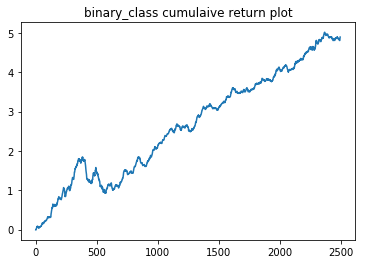

In [231]:
def run_multi_eva(df, type_eva = 'multi_class'):
    tmp_ret = None
    if type_eva == "multi_class":
        tmp_ret = tmp.groupby("datetime").apply(lambda x: multi_class_eva(x))
    if type_eva == "binary_class":
        tmp_ret = tmp.groupby("datetime").apply(lambda x: binary_class_eva(x))
    plt.figure()
    plt.plot(list(tmp_ret.cumsum()))
    plt.title(type_eva + ' cumulaive return plot')
    print("annualized sharpe:", (tmp_ret.mean() / tmp_ret.std()) * np.sqrt(365))
    print("daily sharpe     :", (tmp_ret.mean() / tmp_ret.std()))
    plt.show()
    
run_multi_eva(df, type_eva = "binary_class")

In [232]:
tmp.groupby("datetime").apply(lambda x: binary_class_eva(x)).sum()

4.891846791225575

In [235]:
import random

In [239]:
tmp['random_y'] = [random.choice([1, -1]) for i in range(len(tmp))] 

annualized sharpe: -0.2552677183968719
daily sharpe     : -0.013361323047394477


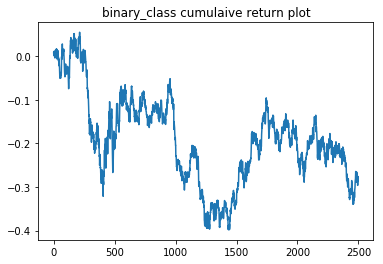

In [240]:
def binary_class_eva(day_df):
    short_porfolio = day_df[(day_df.random_y == -1)]
    long_porfolio  = day_df[(day_df.random_y == 1)]
    return (long_porfolio.returnsOpenNextMktres10).mean() - (short_porfolio.returnsOpenNextMktres10).mean()

def run_multi_eva(df, type_eva = 'multi_class'):
    tmp_ret = None
    if type_eva == "multi_class":
        tmp_ret = tmp.groupby("datetime").apply(lambda x: multi_class_eva(x))
    if type_eva == "binary_class":
        tmp_ret = tmp.groupby("datetime").apply(lambda x: binary_class_eva(x))
    plt.figure()
    plt.plot(list(tmp_ret.cumsum()))
    plt.title(type_eva + ' cumulaive return plot')
    print("annualized sharpe:", (tmp_ret.mean() / tmp_ret.std()) * np.sqrt(365))
    print("daily sharpe     :", (tmp_ret.mean() / tmp_ret.std()))
    plt.show()
    
run_multi_eva(df, type_eva = "binary_class")

annualized sharpe: 3.0294929854872192
daily sharpe     : 0.15857091019232578


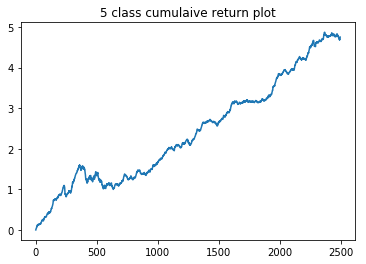

In [227]:
run_multi_eva(df)

In [110]:
from collections import Counter
df.groupby('datetime').apply(lambda x: h(x))

Counter({-1: 365984, 1: 118710})

In [166]:
model_fit.y

array([[  0.94903263,   1.74423768],
       [  1.85272986,   2.69492908],
       [  2.50875137,   3.30889533],
       [  3.96871855,   4.87265629],
       [  4.00040904,   4.83558791],
       [  5.44468879,   6.15062424],
       [  6.92722714,   7.36849654],
       [  7.98988365,   8.41573007],
       [  8.08109285,   8.32995924],
       [  9.28868489,  10.22962186],
       [ 10.7877681 ,  11.19331991],
       [ 11.15116933,  11.72942777],
       [ 12.55854484,  12.86253204],
       [ 13.0949307 ,  13.55127669],
       [ 14.68040222,  15.43434191],
       [ 15.39913285,  15.75054752],
       [ 16.84001784,  16.87629691],
       [ 17.02053376,  17.94231129],
       [ 18.58291829,  19.38164111],
       [ 19.73928507,  20.05775451],
       [ 20.66856295,  20.90150308],
       [ 21.85934709,  22.51880688],
       [ 22.21255406,  22.59586565],
       [ 23.66107545,  24.48994068],
       [ 24.48218175,  24.8501392 ],
       [ 25.45939765,  25.55213842],
       [ 26.68866028,  27.58902091],
 

In [164]:
model

In [163]:
data

[[0.9490326288237589, 1.7442376768180443],
 [1.8527298616198007, 2.694929079424243],
 [2.508751370514448, 3.308895331492579],
 [3.968718554555614, 4.87265628612721],
 [4.000409044331559, 4.8355879095605125],
 [5.444688787675827, 6.1506242430279805],
 [6.927227143971413, 7.368496542816656],
 [7.989883648558598, 8.415730071548566],
 [8.081092854555344, 8.329959236983822],
 [9.28868488638017, 10.229621864445917],
 [10.787768102341097, 11.193319909558287],
 [11.151169328981485, 11.729427766791028],
 [12.558544841461615, 12.862532041140621],
 [13.094930696303077, 13.551276686297829],
 [14.680402218334194, 15.434341905711012],
 [15.399132848470494, 15.750547520245853],
 [16.840017837501684, 16.876296912140436],
 [17.02053375886114, 17.942311292724458],
 [18.582918286888784, 19.381641108928452],
 [19.73928507198929, 20.05775450817608],
 [20.66856295200906, 20.90150308173431],
 [21.859347089702872, 22.518806877506496],
 [22.21255405653747, 22.595865649893955],
 [23.66107545118775, 24.489940678